In [161]:
import yfinance as yf
import pandas as pd
from fredapi import Fred
from datetime import datetime, timedelta

# Set your FRED API key
fred = Fred(api_key='e984fa76b9f2e1eb779a46148c1fd0c9')

print("Getting Data...")

# Set the ticker symbol, start and end dates
ticker = 'QQQ'
end_date = datetime.today()
#start_date = end_date - timedelta(weeks=15)
start_date = end_date - timedelta(weeks=10*52)

# Fetch stock data from Yahoo Finance
stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
#stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1wk')

# Fetch economic data from FRED
interest_rate = fred.get_series('FEDFUNDS', start_date, end_date)
bond_yield = fred.get_series('GS10', start_date, end_date)
cpi = fred.get_series('CPALTT01USM657N', start_date, end_date)
ppi = fred.get_series('PCUOMFGOMFG', start_date, end_date)
unemployment = fred.get_series('UNRATE', start_date, end_date)
gdp = fred.get_series('GDP', start_date, end_date)
gdpc1 = fred.get_series('GDPC1', start_date, end_date)
mthm2 = fred.get_series('M2SL', start_date, end_date)
onfed = fred.get_series('RRPONTSYD', start_date, end_date)
hpi = fred.get_series('CSUSHPINSA', start_date, end_date)
revs = fred.get_series('T10Y3M', start_date, end_date)

print("Data downloaded!")

Getting Data...
[*********************100%***********************]  1 of 1 completed
Data downloaded!


In [162]:
# Merge stock and economic data
combined_df = stock_data.join([interest_rate.rename('interest_rate'), 
                               bond_yield.rename('bond_yield'), 
                               cpi.rename('cpi'), 
                               ppi.rename('ppi'), 
                               unemployment.rename('unemployment'),
                               gdp.rename('gdp'),
                               gdpc1.rename('real_gdp'),
                               mthm2.rename('monthly_m2_s'),
                               onfed.rename('fed_overnight'),
                               hpi.rename('house_price'),
                               revs.rename('rate_reversal')], how='outer')

# Forward-fill missing values
combined_df['interest_rate'].fillna(method='ffill', inplace=True)
combined_df['bond_yield'].fillna(method='ffill', inplace=True)
combined_df['cpi'].fillna(method='ffill', inplace=True)
combined_df['ppi'].fillna(method='ffill', inplace=True)
combined_df['unemployment'].fillna(method='ffill', inplace=True)
combined_df['gdp'].fillna(method='ffill', inplace=True)
combined_df['real_gdp'].fillna(method='ffill', inplace=True)
combined_df['monthly_m2_s'].fillna(method='ffill', inplace=True)
combined_df['fed_overnight'].fillna(method='ffill', inplace=True)
combined_df['house_price'].fillna(method='ffill', inplace=True)
combined_df['rate_reversal'].fillna(method='ffill', inplace=True)

# Set the index to datetime
combined_df.index = pd.to_datetime(combined_df.index)

# Add day_in_week, and day_in_month features
combined_df['day_in_week'] = combined_df.index.dayofweek
combined_df['day_in_month'] = combined_df.index.day

# Drop days without stock price but have econ data
combined_df.dropna(subset=['Close'], inplace=True)

#combined_df.head(20)

In [163]:
# Create time-lagged factors
# Be sure to adjust them when using different time intervals
lag_day = 30

combined_df['interest_rate_lag'] = combined_df['interest_rate'].shift(lag_day)
combined_df['interest_rate_lag'].fillna(method='bfill', inplace=True)

combined_df['bond_yield_lag'] = combined_df['bond_yield'].shift(lag_day)
combined_df['bond_yield_lag'].fillna(method='bfill', inplace=True)

combined_df['cpi_lag'] = combined_df['cpi'].shift(lag_day)
combined_df['cpi_lag'].fillna(method='bfill', inplace=True)

combined_df['monthly_m2_lag'] = combined_df['monthly_m2_s'].shift(lag_day)
combined_df['monthly_m2_lag'].fillna(method='bfill', inplace=True)

combined_df['fed_overnight_lag'] = combined_df['fed_overnight'].shift(lag_day)
combined_df['fed_overnight_lag'].fillna(method='bfill', inplace=True)

combined_df['rate_reversal_lag'] = combined_df['rate_reversal'].shift(lag_day)
combined_df['rate_reversal_lag'].fillna(method='bfill', inplace=True)

combined_df['volume_lag'] = combined_df['Volume'].shift(lag_day)
combined_df['volume_lag'].fillna(method='bfill', inplace=True)

combined_df['unemployment_lag'] = combined_df['unemployment'].shift(lag_day)
combined_df['unemployment_lag'].fillna(method='bfill', inplace=True)

In [164]:
# Drop unnecessary columns
combined_df = combined_df.drop(columns=['Open', 'High', 'Low', 'Adj Close'])

# Rename the 'Close' column to 'stock_price'
combined_df.rename(columns={'Close': 'stock_price'}, inplace=True)

#combined_df.head(20)

In [165]:
combined_df.shape

(2509, 23)

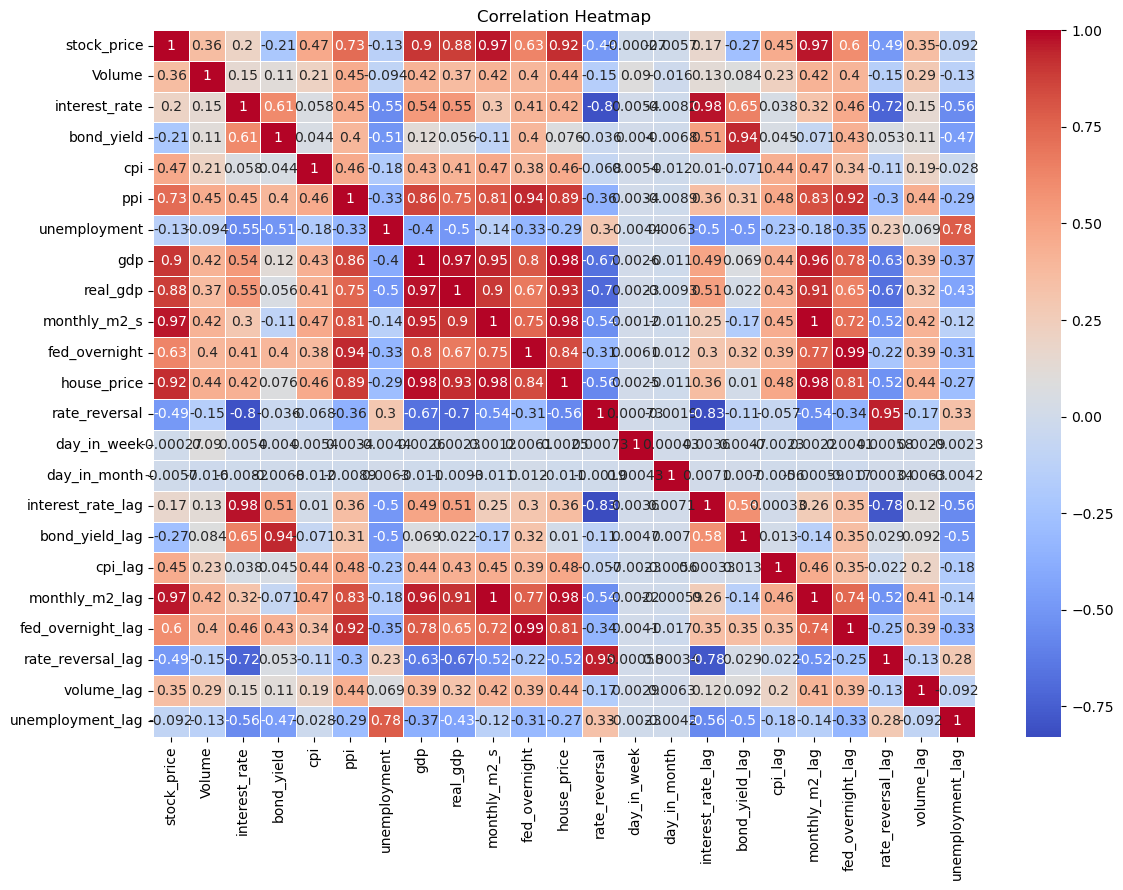

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = combined_df.corr()

# Set up the figure size for the heatmap
plt.figure(figsize=(12, 9))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Customize the plot
plt.title("Correlation Heatmap")
plt.tight_layout()

# Show the plot
#plt.show()

In [167]:
# Select factors and do train-test-split
X = combined_df[['day_in_week', 'day_in_month', 'interest_rate_lag', 'bond_yield_lag',
                 'cpi_lag', 'monthly_m2_lag', 'fed_overnight_lag', 'rate_reversal_lag', 
                 'volume_lag', 'unemployment_lag']]
y = combined_df['stock_price']

train_ratio = 0.98
pred_day = 30
n_total = len(combined_df)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_val, y_val = X.iloc[n_train:], y.iloc[n_train:]

# Create the input for future predictions using the last 5 unshifted data points in the original dataframe
x_pred = combined_df[['day_in_week', 'day_in_month', 'interest_rate', 'bond_yield',
                      'cpi', 'monthly_m2_s', 'fed_overnight', 'rate_reversal', 
                      'Volume', 'unemployment']].iloc[-pred_day:]

# Rename the columns to match the lagged factor names
x_pred.columns = ['day_in_week', 'day_in_month', 'interest_rate_lag', 'bond_yield_lag',
                  'cpi_lag', 'monthly_m2_lag', 'fed_overnight_lag', 'rate_reversal_lag', 
                  'volume_lag', 'unemployment_lag']

x_pred_df = pd.DataFrame(x_pred, columns=X.columns)
last_date = combined_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=pred_day, freq='B')
x_pred_df.index = future_dates
x_pred_df['day_in_week'] = x_pred_df.index.dayofweek
x_pred_df['day_in_month'] = x_pred_df.index.day
#x_pred_df.head(pred_day)

In [168]:
# Build the LSTM model
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

def create_dataset(X, time_step=1):
    Xs = []
    X = pd.DataFrame(X)
    for i in range(len(X) - time_step):
        Xs.append(X.iloc[i:(i + time_step)].values)
    return np.array(Xs)

def create_future_dataset(X_val, X_pred, time_step=1):
    Xs = []
    X_concat = pd.concat([X_val.iloc[-time_step:], X_pred])
    for i in range(len(X_concat) - time_step):
        Xs.append(X_concat.iloc[i:(i + time_step)].values)
    return np.array(Xs)

x_scaler = MinMaxScaler()
X_train_normalized = x_scaler.fit_transform(X_train)
X_val_normalized = x_scaler.transform(X_val)
X_pred_normalized = x_scaler.transform(x_pred_df)

print(X_train_normalized.shape)
print(X_val_normalized.shape)
print(X_pred_normalized.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))

time_steps = 2
X_train_processed = create_dataset(X_train_normalized, time_step=time_steps)
X_val_processed = create_dataset(X_val_normalized, time_step=time_steps)
X_pred_processed = create_future_dataset(pd.DataFrame(X_val_normalized), pd.DataFrame(X_pred_normalized), time_step=time_steps)

print(X_train_processed.shape)
print(X_val_processed.shape)
print(X_pred_processed.shape)

y_train_processed = y_train_scaled[time_steps:]
y_val_processed = y_val_scaled[time_steps:]

model = Sequential([
    LSTM(units=250, return_sequences=True, input_shape=(X_train_processed.shape[1], X_train_processed.shape[2])),
    Dropout(0.15),
    LSTM(units=250, return_sequences=True),
    Dropout(0.15),
    LSTM(units=250, return_sequences=True),
    Dropout(0.15),
    LSTM(units=250, return_sequences=True),
    Dropout(0.15),
    LSTM(units=250, return_sequences=True),
    Dropout(0.15),
    LSTM(units=250),
    Dropout(0.15),
    Dense(units=1)
])

optimizer = Adam(learning_rate=0.002)
model.compile(optimizer=optimizer, loss='mean_squared_error')
print("Model constructed!")

(2458, 10)
(51, 10)
(30, 10)
(2456, 2, 10)
(49, 2, 10)
(30, 2, 10)
Model constructed!


In [169]:
history = model.fit(
    X_train_processed, y_train_processed,
    validation_data=(X_val_processed, y_val_processed),
    epochs=500,
    batch_size=8192
)

Epoch 1/500
1/1 [==============================] - 8s 8s/step - loss: 0.1932 - val_loss: 0.4630
Epoch 2/500
1/1 [==============================] - 0s 297ms/step - loss: 0.1784 - val_loss: 0.4233
Epoch 3/500
1/1 [==============================] - 0s 296ms/step - loss: 0.1602 - val_loss: 0.3680
Epoch 4/500
1/1 [==============================] - 0s 257ms/step - loss: 0.1366 - val_loss: 0.2896
Epoch 5/500
1/1 [==============================] - 0s 214ms/step - loss: 0.1078 - val_loss: 0.1800
Epoch 6/500
1/1 [==============================] - 0s 291ms/step - loss: 0.0795 - val_loss: 0.0497
Epoch 7/500
1/1 [==============================] - 0s 260ms/step - loss: 0.0847 - val_loss: 0.0328
Epoch 8/500
1/1 [==============================] - 0s 249ms/step - loss: 0.0939 - val_loss: 0.0606
Epoch 9/500
1/1 [==============================] - 0s 294ms/step - loss: 0.0802 - val_loss: 0.1002
Epoch 10/500
1/1 [==============================] - 0s 252ms/step - loss: 0.0733 - val_loss: 0.1340
Epoch 11/500

1/1 [==============================] - 0s 258ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 84/500
1/1 [==============================] - 0s 303ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 85/500
1/1 [==============================] - 0s 309ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 86/500
1/1 [==============================] - 0s 308ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 87/500
1/1 [==============================] - 0s 303ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 88/500
1/1 [==============================] - 0s 259ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 89/500
1/1 [==============================] - 0s 305ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 90/500
1/1 [==============================] - 0s 294ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 91/500
1/1 [==============================] - 0s 253ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 92/500
1/1 [==============================] - 0s 288ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 93/500


1/1 [==============================] - 0s 321ms/step - loss: 0.0020 - val_loss: 0.0169
Epoch 165/500
1/1 [==============================] - 0s 317ms/step - loss: 0.0019 - val_loss: 0.0170
Epoch 166/500
1/1 [==============================] - 0s 305ms/step - loss: 0.0019 - val_loss: 0.0153
Epoch 167/500
1/1 [==============================] - 0s 292ms/step - loss: 0.0020 - val_loss: 0.0157
Epoch 168/500
1/1 [==============================] - 0s 299ms/step - loss: 0.0019 - val_loss: 0.0166
Epoch 169/500
1/1 [==============================] - 0s 272ms/step - loss: 0.0019 - val_loss: 0.0156
Epoch 170/500
1/1 [==============================] - 0s 309ms/step - loss: 0.0019 - val_loss: 0.0154
Epoch 171/500
1/1 [==============================] - 0s 311ms/step - loss: 0.0019 - val_loss: 0.0182
Epoch 172/500
1/1 [==============================] - 0s 279ms/step - loss: 0.0020 - val_loss: 0.0152
Epoch 173/500
1/1 [==============================] - 0s 312ms/step - loss: 0.0018 - val_loss: 0.0161
Epoc

1/1 [==============================] - 0s 264ms/step - loss: 0.0016 - val_loss: 0.0141
Epoch 246/500
1/1 [==============================] - 0s 270ms/step - loss: 0.0017 - val_loss: 0.0093
Epoch 247/500
1/1 [==============================] - 0s 314ms/step - loss: 0.0018 - val_loss: 0.0137
Epoch 248/500
1/1 [==============================] - 0s 307ms/step - loss: 0.0017 - val_loss: 0.0127
Epoch 249/500
1/1 [==============================] - 0s 256ms/step - loss: 0.0016 - val_loss: 0.0095
Epoch 250/500
1/1 [==============================] - 0s 304ms/step - loss: 0.0016 - val_loss: 0.0121
Epoch 251/500
1/1 [==============================] - 0s 282ms/step - loss: 0.0016 - val_loss: 0.0112
Epoch 252/500
1/1 [==============================] - 0s 300ms/step - loss: 0.0015 - val_loss: 0.0075
Epoch 253/500
1/1 [==============================] - 0s 305ms/step - loss: 0.0017 - val_loss: 0.0104
Epoch 254/500
1/1 [==============================] - 0s 293ms/step - loss: 0.0016 - val_loss: 0.0114
Epoc

1/1 [==============================] - 0s 306ms/step - loss: 0.0014 - val_loss: 0.0079
Epoch 327/500
1/1 [==============================] - 0s 286ms/step - loss: 0.0014 - val_loss: 0.0084
Epoch 328/500
1/1 [==============================] - 0s 306ms/step - loss: 0.0014 - val_loss: 0.0087
Epoch 329/500
1/1 [==============================] - 0s 315ms/step - loss: 0.0015 - val_loss: 0.0081
Epoch 330/500
1/1 [==============================] - 0s 246ms/step - loss: 0.0015 - val_loss: 0.0083
Epoch 331/500
1/1 [==============================] - 0s 290ms/step - loss: 0.0014 - val_loss: 0.0080
Epoch 332/500
1/1 [==============================] - 0s 293ms/step - loss: 0.0014 - val_loss: 0.0074
Epoch 333/500
1/1 [==============================] - 0s 284ms/step - loss: 0.0014 - val_loss: 0.0074
Epoch 334/500
1/1 [==============================] - 0s 249ms/step - loss: 0.0014 - val_loss: 0.0079
Epoch 335/500
1/1 [==============================] - 0s 267ms/step - loss: 0.0014 - val_loss: 0.0062
Epoc

1/1 [==============================] - 0s 234ms/step - loss: 0.0013 - val_loss: 0.0057
Epoch 408/500
1/1 [==============================] - 0s 302ms/step - loss: 0.0013 - val_loss: 0.0057
Epoch 409/500
1/1 [==============================] - 0s 263ms/step - loss: 0.0013 - val_loss: 0.0081
Epoch 410/500
1/1 [==============================] - 0s 259ms/step - loss: 0.0013 - val_loss: 0.0069
Epoch 411/500
1/1 [==============================] - 0s 247ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 412/500
1/1 [==============================] - 0s 323ms/step - loss: 0.0013 - val_loss: 0.0068
Epoch 413/500
1/1 [==============================] - 0s 304ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 414/500
1/1 [==============================] - 0s 273ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 415/500
1/1 [==============================] - 0s 298ms/step - loss: 0.0013 - val_loss: 0.0067
Epoch 416/500
1/1 [==============================] - 0s 290ms/step - loss: 0.0013 - val_loss: 0.0057
Epoc

1/1 [==============================] - 0s 292ms/step - loss: 0.0012 - val_loss: 0.0060
Epoch 489/500
1/1 [==============================] - 0s 301ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 490/500
1/1 [==============================] - 0s 279ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 491/500
1/1 [==============================] - 0s 303ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 492/500
1/1 [==============================] - 0s 290ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 493/500
1/1 [==============================] - 0s 288ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 494/500
1/1 [==============================] - 0s 260ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 495/500
1/1 [==============================] - 0s 291ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 496/500
1/1 [==============================] - 0s 249ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 497/500
1/1 [==============================] - 0s 232ms/step - loss: 0.0012 - val_loss: 0.0055
Epoc

1/1 [==============================] - 0s 29ms/step


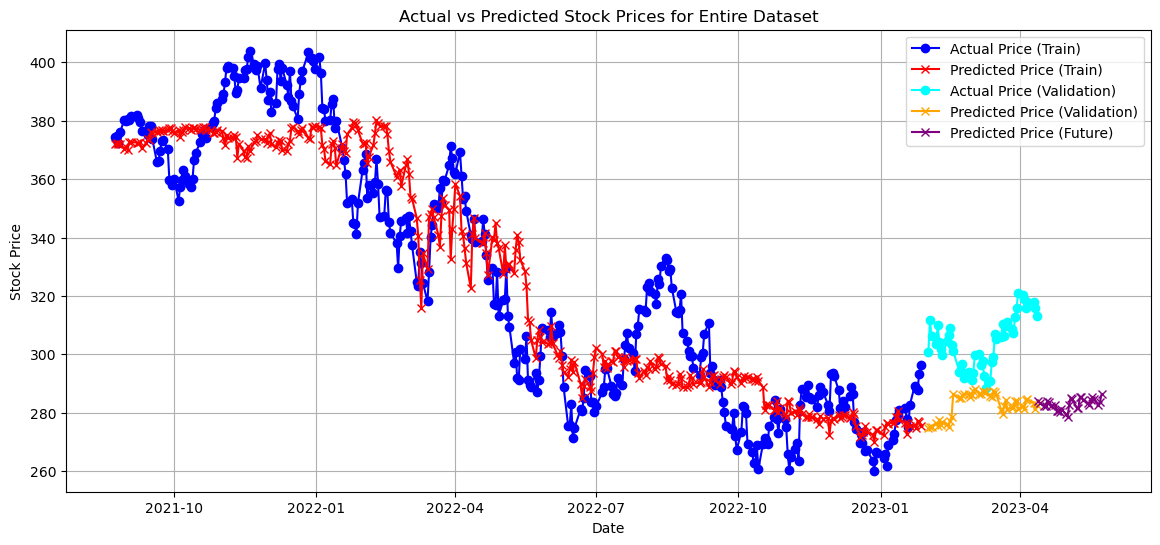

In [171]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make training predictions
y_pred_train = model.predict(X_train_processed)
y_pred_train = y_scaler.inverse_transform(y_pred_train)

# Make validation predictions
y_pred_val = model.predict(X_val_processed)
y_pred_val = y_scaler.inverse_transform(y_pred_val)

# Make future predictions
y_pred_future = model.predict(X_pred_processed)
y_pred_future = y_scaler.inverse_transform(y_pred_future)

# Create a new index for the entire dataset
full_index_train = X_train.index[time_steps:]
full_index_val = X_val.index[time_steps:]
full_index_future = x_pred_df.index

# Cutoff earlier training data
tday = 360
y_train_ori = y_train[time_steps:]

# Plot actual vs predicted for the entire dataset
plt.figure(figsize=(14, 6))
plt.plot(full_index_train[-tday:], y_train_ori[-tday:], label='Actual Price (Train)', color='blue', marker='o')
plt.plot(full_index_train[-tday:], y_pred_train[-tday:], label='Predicted Price (Train)', color='red', marker='x')
plt.plot(full_index_val, y_val[time_steps:], label='Actual Price (Validation)', color='cyan', marker='o')
plt.plot(full_index_val, y_pred_val, label='Predicted Price (Validation)', color='orange', marker='x')
plt.plot(full_index_future, y_pred_future, label='Predicted Price (Future)', color='purple', marker='x')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices for Entire Dataset')
plt.legend()
plt.grid(True)
plt.show()

4/4 [==============================] - 0s 16ms/step
Mean Squared Error: 16465.40
Root Mean Squared Error: 128.32
Mean Absolute Error: 127.89
R-squared Score: -193.23
4/4 [==============================] - 0s 14ms/step


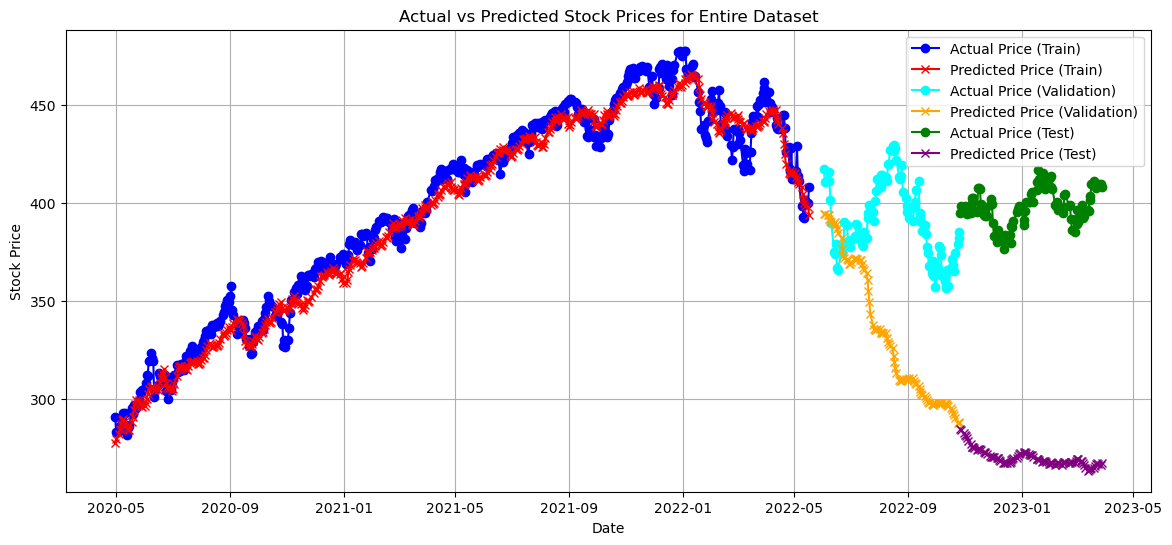

In [47]:
# Make (test) prediction
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test_processed)
y_pred = y_scaler.inverse_transform(y_pred)

# Compute various metrics
y_test_adjusted = y_test[-len(y_pred):]
mse = mean_squared_error(y_test_adjusted, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_adjusted, y_pred)
r2 = r2_score(y_test_adjusted, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared Score: {r2:.2f}')

# Make training predictions
y_pred_train = model.predict(X_train_processed)
y_pred_train = y_scaler.inverse_transform(y_pred_train)

# Merge training and test predictions
y_pred_all = np.concatenate((y_pred_train, y_pred))
y_actual_all = np.concatenate((y_train[time_steps:], y_test_adjusted))

# Create a new index for the entire dataset
full_index_train = X_train.index[time_steps:]
full_index_test = X_test.index[:len(y_test_adjusted)]

# Make validation predictions
y_pred_val = model.predict(X_val_processed)
y_pred_val = y_scaler.inverse_transform(y_pred_val)

# Create a new index for the entire dataset
full_index_val = X_val.index[time_steps:]

# Plot actual vs predicted for the entire dataset
plt.figure(figsize=(14, 6))
plt.plot(full_index_train, y_train[time_steps:], label='Actual Price (Train)', color='blue', marker='o')
plt.plot(full_index_train, y_pred_train, label='Predicted Price (Train)', color='red', marker='x')
plt.plot(full_index_val, y_val[time_steps:], label='Actual Price (Validation)', color='cyan', marker='o')
plt.plot(full_index_val, y_pred_val, label='Predicted Price (Validation)', color='orange', marker='x')
plt.plot(full_index_test, y_test_adjusted, label='Actual Price (Test)', color='green', marker='o')
plt.plot(full_index_test, y_pred, label='Predicted Price (Test)', color='purple', marker='x')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices for Entire Dataset')
plt.legend()
plt.grid(True)
plt.show()